In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import json

import warnings
warnings.filterwarnings("ignore")

# Configura para que os plots sejam exibidos diretamente no notebook
%matplotlib inline

# Seleção dos Melhores Modelos
##### Datasets:
- **Original** - Original com 50 mil registros sendo que 20% são anomalias
- **SS**       - Padronizado com _StandardScaler_
- **RS**       - Padronizado com _RobustScaler_
- **PT**       - Padronizado e Normalizado com _PowerTransformer_
- **Reduzida** - Original com atributos reduzidos

##### Algoritmos:
- **xgb** - XGBoost Classifier
- **rdf** - Random Forest Classifier
- **isf** - Isolation Forest
- **lof** - Local Outlier Factor
- **knn** - K-Nearest Neighbors 

##### Métricas:
- **Acurácia**
- **Precisão**
- **Recall**
- **F2**
- **ROC**
- **Kappa**

## Obtenção dos Dados

In [2]:
df = pd.read_csv('Resultados/resultado_busca.txt', sep = ';', encoding='latin', )

In [3]:
pd.options.display.max_rows = 1000

## Funções Auxiliares

In [4]:
def algoritmos():
    nomes = {'xgb': 'XGB Classifier',
             'rdf': 'Random Forest Classifier',
             'isf': 'Isolation Forest',
             'knn': 'K Nearest KNeighbors',
             'lof': 'Local Outlier Factor'}
    return nomes
nomes = algoritmos()

In [5]:
# Colocar label com valores nos gráficos de barra
def autolabel(rects, f, ax=None):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height-0.1),
                    ha='center', va='bottom', fontsize=10)


In [6]:
### Se desejar usar o valor da diferença entre treinamento e validação como seleção
def truncate(num,n):
    temp = str(num)
    for x in range(len(temp)):
        if temp[x] == '.':
            try:
                return float(temp[:x+n+1])
            except:
                return float(temp)      
    return float(temp)

In [7]:
def consulta_modelos(dataset='', tipo='', metrica=''):
    if dataset == '':
        datasets = df.dataset.unique()
    else:
        datasets = [dataset]
    if tipo == '':
        tipos = df.tipo.unique()
    else:
        tipos = [tipo]        
    if metrica == '':
        metricas = df.metrica.unique()
    else:
        metricas = [metrica]        

    df_aux = pd.DataFrame(data=None, columns=df.columns)
    df_aux['melhor'] = ''

    # Calcula a diferença entre o valor de treinamento e teste
    df_dif = df.copy()
    df_dif['dif'] = df_dif['mean_train']-df_dif['mean_test']
    
    for dataset in datasets:
        for tipo in tipos:
            for score in metricas:

                # Seleciona o maior valor da métrica no treinamento (com três casas decimais)
                valor_max = truncate(df_dif.query('dataset=="'+dataset+'" and metrica== "'+score+'" and tipo=="'+tipo+'"').mean_test.max(),3)
                # Seleciona o modelo com a menor diferença entre treinamento e teste que tenha métricado treinamento maior ou igual a escolhida acima
                valor_min = df_dif.query('dataset=="'+dataset+'" and mean_test >= ' + str(valor_max) + ' and metrica== "'+score+'" and tipo=="'+tipo+'"').dif.min()
                aux = df_dif.query('dataset=="' + dataset + '" and dif == ' + str(valor_min) + ' and mean_test >= ' + str(valor_max) + ' and metrica== "'+score+'" and tipo=="'+tipo+'"').groupby(['param','hora_inicio']).mean_test.max().reset_index().sort_values(by='mean_test', ascending=False).head(1)
                #aux = df.query('dataset=="'+dataset+'" and metrica== "'+score+'" and tipo=="'+tipo+'"').groupby(['param','hora_inicio']).mean_test.max().reset_index().sort_values(by='mean_test', ascending=False).head(1)                
                if aux.shape[0] > 0:
                    param = aux.iloc[0]['param']
                    hi = aux.iloc[0]['hora_inicio']
                    aux = df.query('dataset=="'+dataset+'" and tipo=="'+tipo+'" and param=="'+param+'" and hora_inicio=="'+hi+'"').copy()
                    aux['melhor'] = score
                    df_aux = df_aux.append(aux)               
                    
    return df_aux

In [8]:
# Se informar a metrica retorna o melhor modelo daquela métrica mesmo que único esteja como False
def melhores_modelos(dataset='', tipo='', metrica='', modelo=False):
    df_aux = consulta_modelos(dataset, tipo, metrica)
    if metrica!='' or modelo:
        # Retorna os melhores modelos de forma única (métricas desse melhor modelo)
        return (df_aux.pivot_table('mean_test',['dataset','tipo', 'melhor'], 'metrica', aggfunc='max').style.highlight_max(axis=0))
    else:
        # Retorna os modelos das melhores métricas de forma independente
        return (df_aux.query('melhor==metrica').pivot_table('mean_test',['dataset','tipo'], 'metrica', aggfunc='max').style.highlight_max(axis=0))
        

In [9]:
def parametros_modelos(dataset='', tipo='', metrica=''):
    df_aux = consulta_modelos(dataset, tipo, metrica)

    print("MELHORES MODELOS POR MÉTRICA (INDEPENDENTE)")
    for i, row in df_aux.iterrows():
        if row['metrica'] == row['melhor']:
            print('Dataset:', row['dataset'], ' - Algoritmo:', row['tipo'], ' - Métrica:', row['metrica'], ' : ', row['mean_test'])
            print(row['param'])


In [10]:
def grafico_modelos(dataset='', tipo=''):
    j = 0
    metrica=''
    if dataset!='':
        nome = ['dataset', 'tipo', 'metrica']
        titulo = "Dataset: " + dataset
    else:
        nome = ['tipo', 'dataset', 'metrica']
        titulo = nomes[tipo]
        
    df_modelos = consulta_modelos(dataset, tipo, metrica).query('metrica == melhor')
    i = 0
    bar_width = 0.15
    df_nome = df_modelos[nome[1]].unique() 
    fig, ax = plt.subplots(figsize=(15, 4))
    for modelo in df_nome:
        res = df_modelos.query(nome[1]+'=="'+modelo+'"').sort_values(by=nome[2])
        x =  np.arange(len(res)) + i*bar_width
        rec = ax.bar(x, res['mean_test'], width=bar_width, label = modelo)
        autolabel(rec, '{0:.2f}', ax)
        i += 1

    qtde = len(res)-1
    plt.xticks([(x + bar_width*((qtde-1)/2)) for x in range(len(res[nome[2]]))], res[nome[2]])
    plt.legend()

    plt.title("Análise das Métricas - " + titulo)
    plt.show()    

In [11]:
# Gera gráfico comparativo entre treinamento x validação
def grafico_metricas(dataset, tipo, zoom=False):
    metricas=['Acurácia', 'Precisão', 'Recall', 'F1', 'MCC', 'ROC']
    plt.figure(figsize=(15, 10))
    i = 1
    for metrica in metricas:
        plt.subplot(2, 3, i)    
        metricas = df.query('metrica=="'+metrica+'" and dataset=="'+dataset+'" and tipo=="'+tipo+'"').groupby('mean_train').mean_test.max().reset_index()
        x =  np.arange(metricas.shape[0])
        if not zoom:
            plt.axis([0, metricas.shape[0], 0, 1]) # [xmin, xmax, ymin, ymax]
        plt.plot(x, metricas['mean_train'], color='green', label='Treinamento')
        plt.plot(x, metricas['mean_test'], color='blue', label='Validação')
        plt.title(dataset +" - "+  tipo + " - " + metrica)
        plt.xticks([],[])
        plt.legend(loc='best')
        i += 1
    plt.show()


## Analisando Algoritmos - Seleção melhores modelos

- Função: melhor_modelo(dataset, tipo, metrica)
    - Ao informar a métrica será retornado o mehor modelo para a métrica informada

### Análise por dataset

In [12]:
# Melhores métricas de forma independente
melhores_modelos('Original')

In [13]:
# Melhores métricas de forma independente
melhores_modelos('SS')

In [14]:
# Melhores métricas de forma independente
melhores_modelos('RS')

In [15]:
# Melhores métricas de forma independente
melhores_modelos('PT')

In [16]:
# Melhores métricas de forma independente
melhores_modelos('Reduzida')

### Melhores modelos por algoritmo

In [17]:
# Melhores métricas de forma independente
melhores_modelos(tipo = 'xgb')

,metrica,Acurácia,F1,MCC,Precisão,ROC,Recall
dataset,tipo,,,,,,
Original,xgb,0.902402,0.940100,0.673158,0.915228,0.803062,0.979038
PT,xgb,0.902402,0.940545,0.672088,0.914130,0.801430,0.980158
RS,xgb,0.902402,0.940100,0.673158,0.915234,0.803098,0.979038
Reduzida,xgb,0.897106,0.938170,0.654959,0.911509,0.793339,0.978640
SS,xgb,0.902547,0.940266,0.673432,0.915290,0.803605,0.979074


In [18]:
# Melhores métricas de forma independente
melhores_modelos(tipo = 'rdf')

,metrica,Acurácia,F1,MCC,Precisão,ROC,Recall
dataset,tipo,,,,,,
Original,rdf,0.897106,0.938118,0.656039,0.943768,0.829952,0.979219
PT,rdf,0.897713,0.938089,0.655761,0.914465,0.799517,0.970942
RS,rdf,0.897019,0.938097,0.656141,0.915667,0.801936,0.970509
Reduzida,rdf,0.891172,0.933403,0.637126,0.917239,0.801155,0.961437
SS,rdf,0.897308,0.938008,0.656909,0.915520,0.801645,0.970075


In [19]:
# Melhores métricas de forma independente
melhores_modelos(tipo = 'knn')

,metrica,Acurácia,F1,MCC,Precisão,ROC,Recall
dataset,tipo,,,,,,
Original,knn,0.813748,0.895324,0.223024,0.814059,0.540542,0.999133
PT,knn,0.809899,0.892606,0.199935,0.815044,0.543162,0.995410
RS,knn,0.810796,0.893240,0.204004,0.814821,0.542575,0.993350
Reduzida,knn,0.870159,0.923933,0.540064,0.870280,0.697232,0.989916
SS,knn,0.817135,0.896341,0.255698,0.820769,0.560182,0.991868


In [20]:
# Melhores métricas de forma independente
melhores_modelos(tipo = 'lof')

,metrica,Acurácia,F1,MCC,Precisão,ROC,Recall
dataset,tipo,,,,,,
Original,lof,0.741158,0.841613,0.137656,0.825583,0.564502,0.858723
PT,lof,0.798061,0.886709,0.077073,0.805284,0.513631,0.986808
RS,lof,0.737800,0.841872,0.081669,0.814146,0.535762,0.871553
Reduzida,lof,0.738842,0.842714,0.081075,0.813927,0.535266,0.873613
SS,lof,0.762084,0.860247,0.086036,0.812433,0.532321,0.914345


In [21]:
# Melhores métricas de forma independente
melhores_modelos(tipo = 'isf')

,metrica,Acurácia,F1,MCC,Precisão,ROC,Recall
dataset,tipo,,,,,,
Original,isf,0.800926,0.889354,0.121179,0.825056,0.560730,0.999129
PT,isf,0.786599,0.878239,0.122393,0.825589,0.561633,0.961107
RS,isf,0.800926,0.889354,0.121905,0.825200,0.561095,0.999129
Reduzida,isf,0.801910,0.889693,0.235761,0.848030,0.618250,0.998266
SS,isf,0.800926,0.889354,0.120169,0.824839,0.560206,0.999129


### Análise dos melhores modelos para cada métrica por algoritmo

#### XGB

In [22]:
# Valor das métricas de um modelo selecionado pelo melhor valor de um métrica
melhores_modelos('Original', tipo = 'xgb', modelo=True)

In [23]:
# Valor das métricas de um modelo selecionado pelo melhor valor de um métrica
melhores_modelos('SS', tipo = 'xgb', modelo=True)

In [24]:
# Valor das métricas de um modelo selecionado pelo melhor valor de um métrica
melhores_modelos('RS', tipo = 'xgb', modelo=True)

In [25]:
# Valor das métricas de um modelo selecionado pelo melhor valor de um métrica
melhores_modelos('PT', tipo = 'xgb', modelo=True)

In [26]:
# Valor das métricas de um modelo selecionado pelo melhor valor de um métrica
melhores_modelos('Reduzida', tipo = 'xgb', modelo=True)

#### RDF

In [27]:
# Valor das métricas de um modelo selecionado pelo melhor valor de um métrica
melhores_modelos('Original', tipo = 'rdf', modelo=True)

In [28]:
# Valor das métricas de um modelo selecionado pelo melhor valor de um métrica
melhores_modelos('SS', tipo = 'rdf', modelo=True)

In [29]:
# Valor das métricas de um modelo selecionado pelo melhor valor de um métrica
melhores_modelos('RS', tipo = 'rdf', modelo=True)

In [30]:
# Valor das métricas de um modelo selecionado pelo melhor valor de um métrica
melhores_modelos('PT', tipo = 'rdf', modelo=True)

In [31]:
# Valor das métricas de um modelo selecionado pelo melhor valor de um métrica
melhores_modelos('Reduzida', tipo = 'rdf', modelo=True)

#### KNN

In [32]:
# Valor das métricas de um modelo selecionado pelo melhor valor de um métrica
melhores_modelos('Original', tipo = 'knn', modelo=True)

In [33]:
# Valor das métricas de um modelo selecionado pelo melhor valor de um métrica
melhores_modelos('SS', tipo = 'knn', modelo=True)

In [34]:
# Valor das métricas de um modelo selecionado pelo melhor valor de um métrica
melhores_modelos('RS', tipo = 'knn', modelo=True)

In [35]:
# Valor das métricas de um modelo selecionado pelo melhor valor de um métrica
melhores_modelos('PT', tipo = 'knn', modelo=True)

In [36]:
# Valor das métricas de um modelo selecionado pelo melhor valor de um métrica
melhores_modelos('Reduzida', tipo = 'knn', modelo=True)

#### LOF

In [37]:
# Valor das métricas de um modelo selecionado pelo melhor valor de um métrica
melhores_modelos('Original', tipo = 'lof', modelo=True)

In [38]:
# Valor das métricas de um modelo selecionado pelo melhor valor de um métrica
melhores_modelos('SS', tipo = 'lof', modelo=True)

In [39]:
# Valor das métricas de um modelo selecionado pelo melhor valor de um métrica
melhores_modelos('RS', tipo = 'lof', modelo=True)

In [40]:
# Valor das métricas de um modelo selecionado pelo melhor valor de um métrica
melhores_modelos('PT', tipo = 'lof', modelo=True)

In [41]:
# Valor das métricas de um modelo selecionado pelo melhor valor de um métrica
melhores_modelos('Reduzida', tipo = 'lof', modelo=True)

#### ISF

In [42]:
# Valor das métricas de um modelo selecionado pelo melhor valor de um métrica
melhores_modelos('Original', tipo = 'isf', modelo=True)

In [43]:
# Valor das métricas de um modelo selecionado pelo melhor valor de um métrica
melhores_modelos('SS', tipo = 'isf', modelo=True)

In [44]:
# Valor das métricas de um modelo selecionado pelo melhor valor de um métrica
melhores_modelos('RS', tipo = 'isf', modelo=True)

In [45]:
# Valor das métricas de um modelo selecionado pelo melhor valor de um métrica
melhores_modelos('PT', tipo = 'isf', modelo=True)

In [46]:
# Valor das métricas de um modelo selecionado pelo melhor valor de um métrica
melhores_modelos('Reduzida', tipo = 'isf', modelo=True)

## Gráficos

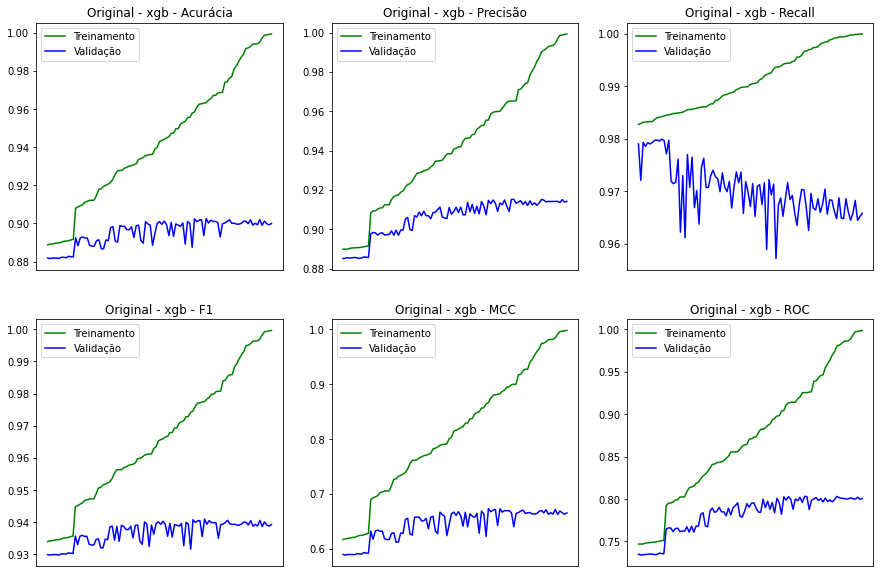

In [47]:
grafico_metricas('Original', 'xgb', True)

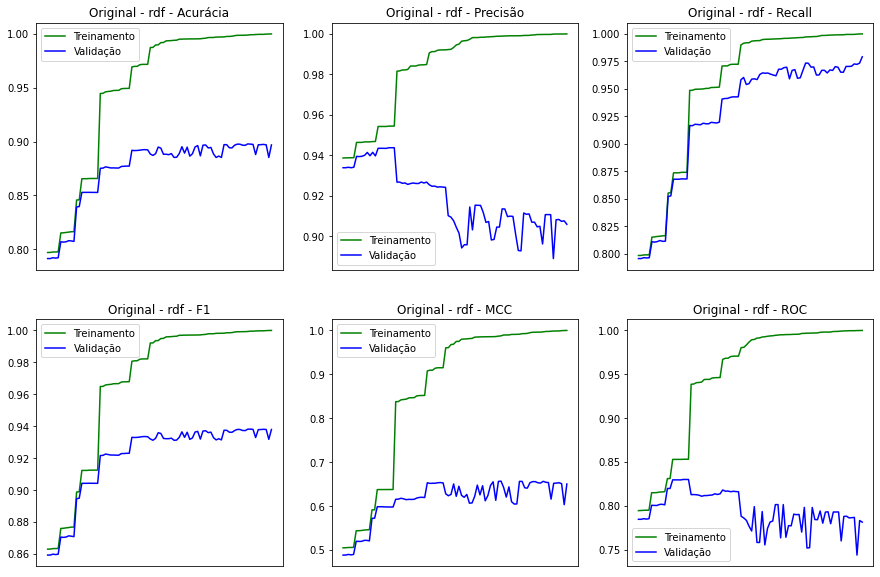

In [48]:
grafico_metricas('Original', 'rdf', True)

### Gráficos de Barras

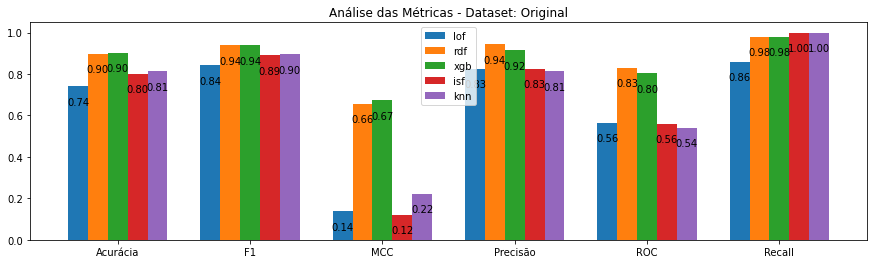

In [49]:
grafico_modelos('Original')

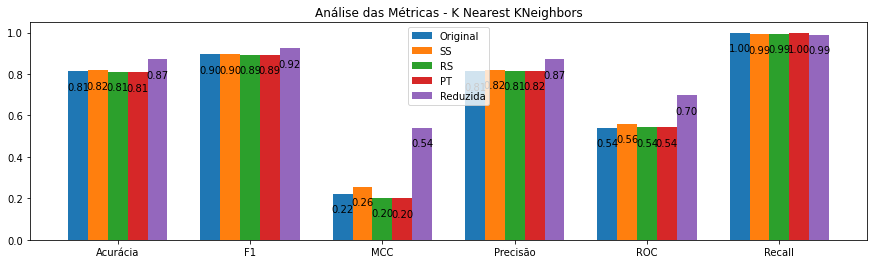

In [50]:
grafico_modelos(tipo='knn')

## Modelos Selecionados

#### Função: parametros_modelos (dataset, tipo, metrica)


In [51]:
# Melhores modelos para cada métrica de forma independente
parametros_modelos('Original', 'xgb')

MELHORES MODELOS POR MÉTRICA (INDEPENDENTE)
Dataset: Original  - Algoritmo: xgb  - Métrica: Acurácia  :  0.9024023154848044
{'n_estimators': 99, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.3, 'gamma': 1}
Dataset: Original  - Algoritmo: xgb  - Métrica: Precisão  :  0.915228241079674
{'n_estimators': 45, 'min_child_weight': 1, 'max_depth': 20, 'learning_rate': 0.3, 'gamma': 5}
Dataset: Original  - Algoritmo: xgb  - Métrica: Recall  :  0.9790378927604004
{'n_estimators': 45, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 5}
Dataset: Original  - Algoritmo: xgb  - Métrica: F1  :  0.9401001375665066
{'n_estimators': 45, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.3, 'gamma': 2}
Dataset: Original  - Algoritmo: xgb  - Métrica: MCC  :  0.6731580272151327
{'n_estimators': 99, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.3, 'gamma': 1}
Dataset: Original  - Algoritmo: xgb  - Métrica: ROC  :  0.8030619285230053
{'n_estimators': 45, 'm

In [52]:
# Melhores modelos para cada métrica de forma independente
parametros_modelos('SS', 'xgb')

MELHORES MODELOS POR MÉTRICA (INDEPENDENTE)
Dataset: SS  - Algoritmo: xgb  - Métrica: Acurácia  :  0.902547033285094
{'n_estimators': 99, 'min_child_weight': 3, 'max_depth': 20, 'learning_rate': 0.1, 'gamma': 5}
Dataset: SS  - Algoritmo: xgb  - Métrica: Precisão  :  0.9152897314283018
{'n_estimators': 45, 'min_child_weight': 1, 'max_depth': 20, 'learning_rate': 0.3, 'gamma': 5}
Dataset: SS  - Algoritmo: xgb  - Métrica: Recall  :  0.9790740329844698
{'n_estimators': 45, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 5}
Dataset: SS  - Algoritmo: xgb  - Métrica: F1  :  0.94026649780113
{'n_estimators': 99, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 5}
Dataset: SS  - Algoritmo: xgb  - Métrica: MCC  :  0.6734315615427884
{'n_estimators': 99, 'min_child_weight': 3, 'max_depth': 20, 'learning_rate': 0.1, 'gamma': 5}
Dataset: SS  - Algoritmo: xgb  - Métrica: ROC  :  0.8036054599224979
{'n_estimators': 99, 'min_child_weight': 3, 'max_depth': 1

In [53]:
# Melhores modelos para cada métrica de forma independente
parametros_modelos('Original', 'rdf')

MELHORES MODELOS POR MÉTRICA (INDEPENDENTE)
Dataset: Original  - Algoritmo: rdf  - Métrica: Acurácia  :  0.8971056439942113
{'n_estimators': 400, 'min_samples_split': 5, 'min_impurity_decrease': 0.0001, 'max_features': None, 'max_depth': 20, 'criterion': 'entropy'}
Dataset: Original  - Algoritmo: rdf  - Métrica: Precisão  :  0.9437684962543524
{'n_estimators': 400, 'min_samples_split': 7, 'min_impurity_decrease': 0.001, 'max_features': None, 'max_depth': 20, 'criterion': 'entropy'}
Dataset: Original  - Algoritmo: rdf  - Métrica: Recall  :  0.9792186330713032
{'n_estimators': 400, 'min_samples_split': 2, 'min_impurity_decrease': 1e-05, 'max_features': 'auto', 'max_depth': 40, 'criterion': 'entropy'}
Dataset: Original  - Algoritmo: rdf  - Métrica: F1  :  0.9381177650449932
{'n_estimators': 300, 'min_samples_split': 7, 'min_impurity_decrease': 1e-05, 'max_features': None, 'max_depth': 40, 'criterion': 'entropy'}
Dataset: Original  - Algoritmo: rdf  - Métrica: MCC  :  0.6560394567361671
{'

In [54]:
parametros_modelos('SS', 'rdf')

MELHORES MODELOS POR MÉTRICA (INDEPENDENTE)
Dataset: SS  - Algoritmo: rdf  - Métrica: Acurácia  :  0.8973082489146165
{'n_estimators': 300, 'min_samples_split': 5, 'min_impurity_decrease': 0.0001, 'max_features': None, 'max_depth': 20, 'criterion': 'entropy'}
Dataset: SS  - Algoritmo: rdf  - Métrica: Precisão  :  0.9155200395377784
{'n_estimators': 300, 'min_samples_split': 7, 'min_impurity_decrease': 0.0001, 'max_features': None, 'max_depth': 20, 'criterion': 'entropy'}
Dataset: SS  - Algoritmo: rdf  - Métrica: Recall  :  0.9700748689843394
{'n_estimators': 300, 'min_samples_split': 5, 'min_impurity_decrease': 0.0001, 'max_features': None, 'max_depth': 30, 'criterion': 'entropy'}
Dataset: SS  - Algoritmo: rdf  - Métrica: F1  :  0.9380075568063578
{'n_estimators': 300, 'min_samples_split': 5, 'min_impurity_decrease': 0.0001, 'max_features': None, 'max_depth': 30, 'criterion': 'entropy'}
Dataset: SS  - Algoritmo: rdf  - Métrica: MCC  :  0.6569089778192895
{'n_estimators': 300, 'min_samp

In [55]:
parametros_modelos('Reduzida', 'knn')

MELHORES MODELOS POR MÉTRICA (INDEPENDENTE)
Dataset: Reduzida  - Algoritmo: knn  - Métrica: Acurácia  :  0.8701591895803183
{'n_neighbors': 35}
Dataset: Reduzida  - Algoritmo: knn  - Métrica: Precisão  :  0.8702802012043179
{'n_neighbors': 35}
Dataset: Reduzida  - Algoritmo: knn  - Métrica: Recall  :  0.9899164921108432
{'n_neighbors': 99}
Dataset: Reduzida  - Algoritmo: knn  - Métrica: F1  :  0.9239328368427988
{'n_neighbors': 35}
Dataset: Reduzida  - Algoritmo: knn  - Métrica: MCC  :  0.5400637913261523
{'n_neighbors': 35}
Dataset: Reduzida  - Algoritmo: knn  - Métrica: ROC  :  0.6972315470917463
{'n_neighbors': 35}


In [56]:
parametros_modelos('Original', 'lof')

MELHORES MODELOS POR MÉTRICA (INDEPENDENTE)
Dataset: Original  - Algoritmo: lof  - Métrica: Acurácia  :  0.7411577424023155
{'n_neighbors':15, 'contamination':'auto'}
Dataset: Original  - Algoritmo: lof  - Métrica: Precisão  :  0.8255830142707969
{'n_neighbors':30, 'contamination':'auto'}
Dataset: Original  - Algoritmo: lof  - Métrica: Recall  :  0.8587227583215873
{'n_neighbors':15, 'contamination':'auto'}
Dataset: Original  - Algoritmo: lof  - Métrica: F1  :  0.8416130917592052
{'n_neighbors':15, 'contamination':'auto'}
Dataset: Original  - Algoritmo: lof  - Métrica: MCC  :  0.13765615787038893
{'n_neighbors':30, 'contamination':'auto'}
Dataset: Original  - Algoritmo: lof  - Métrica: ROC  :  0.5645018903764096
{'n_neighbors':30, 'contamination':'auto'}


In [57]:
parametros_modelos('Original', 'isf')

MELHORES MODELOS POR MÉTRICA (INDEPENDENTE)
Dataset: Original  - Algoritmo: isf  - Métrica: Acurácia  :  0.8009261939218524
{'n_estimators': 100, 'max_samples': 1.0, 'max_features': 1.0, 'contamination': 'auto'}
Dataset: Original  - Algoritmo: isf  - Métrica: Precisão  :  0.8250557560332125
{'n_estimators': 300, 'max_samples': 0.7, 'max_features': 1.0, 'contamination': 0.2}
Dataset: Original  - Algoritmo: isf  - Métrica: Recall  :  0.9991289677128355
{'n_estimators': 100, 'max_samples': 1.0, 'max_features': 1.0, 'contamination': 'auto'}
Dataset: Original  - Algoritmo: isf  - Métrica: F1  :  0.8893540395463978
{'n_estimators': 100, 'max_samples': 1.0, 'max_features': 1.0, 'contamination': 'auto'}
Dataset: Original  - Algoritmo: isf  - Métrica: MCC  :  0.12117881204923014
{'n_estimators': 300, 'max_samples': 0.7, 'max_features': 1.0, 'contamination': 0.2}
Dataset: Original  - Algoritmo: isf  - Métrica: ROC  :  0.5607302390537265
{'n_estimators': 300, 'max_samples': 0.7, 'max_features': 1